In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.interpolate import interp1d

### Simulating the data

In [224]:
class LiRinzel:
    def __init__(self, params):
        self.params = params

    def simulate(self, V2, V3, time, tol = 1e-5):
        params = self.params
        params['v2'] = V2
        params['v3'] = V3
        Ca = np.zeros(len(time))
        h = np.zeros(len(time))
        gh = np.zeros(len(time))

        Ca[0] = 0.1
        h[0] = 0.1

        # np.random.seed(809)
        gh[0] = np.random.randn()

        # Simulation loop
        for t in range(1, len(time)):
            CaER = (params['c0'] - Ca[t-1]) / (params['c1'] + tol)
            pinf = params['IP3'] / (params['IP3'] + params['d1'] + tol)
            Q2 = params['d2'] * ((params['IP3'] + params['d1']) / (params['IP3'] + params['d3'] + tol))
            ninf = Ca[t-1] / (Ca[t-1] + params['d5'] + tol)
            tauh = 1 / (params['a2'] * (Q2 + Ca[t-1]) + tol)
            hinf = Q2 / (Q2 + Ca[t-1] + tol)
            alphah = hinf / (tauh + tol)
            betah = (1 - hinf) / (tauh + tol)

            dh = alphah * (1 - h[t-1]) - betah * (h[t-1]) + gh[t-1] * np.sqrt(params['dt'])
            dCa = params['c1'] * params['v1'] * (pinf**3) * (ninf**3) * (h[t-1]**3) * (CaER - Ca[t-1]) + \
                  params['c1'] * params['v2'] * (CaER - Ca[t-1]) - \
                  params['v3'] * ((Ca[t-1]**2) / (Ca[t-1]**2 + params['k3'] + tol))

            Ca[t] = Ca[t-1] + dCa * params['dt']
            h[t] = h[t-1] + params['dt'] * dh + gh[t-1] * np.sqrt(params['dt'])
            gh[t] = params['dt'] * np.random.randn()

        for i in range(len(Ca)):
            if Ca[i] < 0:
                Ca[i] = 0
            # Check for NaN, inf and -inf and replace with 0
            elif not np.isfinite(Ca[i]):
                Ca[i] = 0

        return Ca

    def PCA(self, data, n_dim = 2):
        data = np.nan_to_num( data, nan = 0.0, posinf = 0.0, neginf = 0.0)
        data = data - np.mean(data , axis=0)

        cov_matrix = np.cov(data.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # Sort eigenvalues and corresponding eigenvectors
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        v_matrix = eigenvectors[:, :n_dim]
        transformed_data = np.dot(data, v_matrix)
        return transformed_data, v_matrix

    def RMSE(self, experimental_data, simulated_data):
        return np.sqrt(np.mean((experimental_data - simulated_data) ** 2))

    def KLDivergence(self, experimental_data, simulated_data, tol=1e-10):
        mu_exp, std_exp = norm.fit(experimental_data)
        mu_sim, std_sim = norm.fit(simulated_data)
        exp = norm.pdf(experimental_data, mu_exp, std_exp)
        sim = norm.pdf(simulated_data, mu_sim, std_sim)
        KL_divergence = sum(experimental_data * np.log((exp + tol) / (sim + tol)))

        return KL_divergence

    def get_optimised_params(self, data, time, initial_guess=[0.1, 0.1], optimizer='RMSE'):
        # Objective function to minimize: RMSE or KL divergence between simulated and experimental data
        def objective(v_params):
            V2, V3 = v_params
            simulated_data = self.simulate(V2, V3, time)

            if optimizer == 'RMSE':
                res = self.RMSE(data, simulated_data)
            elif optimizer == 'KLD':
                res = self.KLDivergence(data, simulated_data)
            return res

        # Optimize V2 and V3 using minimize from scipy
        result = minimize(objective, initial_guess, method='Nelder-Mead')

        # Optimal parameters
        v2_opt, v3_opt = result.x
        return v2_opt, v3_opt

    def fit(self, data, time, optimizer='RMSE'):

        if not time.dtype.kind in 'iuf':
            time = pd.to_numeric(time, errors='coerce') # Coerce errors to NaN, if any
            time = time.fillna(0).astype(int)

        intervals = np.arange(0, len(time), 200)
        v2_opt_list = []
        v3_opt_list = []
        objective_loss = []
        v2_opt, v3_opt = 1, 1
        plt.figure(figsize=(15, 20))

        for index, i in enumerate(intervals):
            v2_opt, v3_opt = self.get_optimised_params(data[i:i+200], time[i:i+200], initial_guess = [v2_opt, v3_opt],optimizer=optimizer)
            v2_opt_list.append(v2_opt)
            v3_opt_list.append(v3_opt)
            sim = self.simulate(v2_opt, v3_opt, time[i:i+200])

            if optimizer == 'RMSE':
                rmse = self.RMSE(data[i:i+200],sim)
                objective_loss.append(rmse)
            if optimizer == 'KLD':
                kld = self.KLDivergence(data[i:i+200], sim)
                objective_loss.append(kld)

            plt.subplot(len(intervals), 1, index+1)

            plt.plot(time[i:i+200], sim, 'r-', alpha = 0.6 , label = 'simulated')
            plt.plot(time[i:i+200], data[i:i+200], 'b-', alpha = 0.6, label = 'experimental')
            plt.title(f"Segment {index+1} - Optimized Parameters: v2={v2_opt:.4f}, v3={v3_opt:.4f}, loss = {objective_loss[-1]:.4f}")
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.legend()

        plt.subplots_adjust(hspace=1)
        plt.show()


        sim_data = self.simulate(v2_opt, v3_opt, time)
        return sim_data, objective_loss, v2_opt_list, v3_opt_list


<ipython-input-224-b25bf10b18bc>:33: RuntimeWarning:

overflow encountered in scalar power

<ipython-input-224-b25bf10b18bc>:33: RuntimeWarning:

invalid value encountered in scalar divide



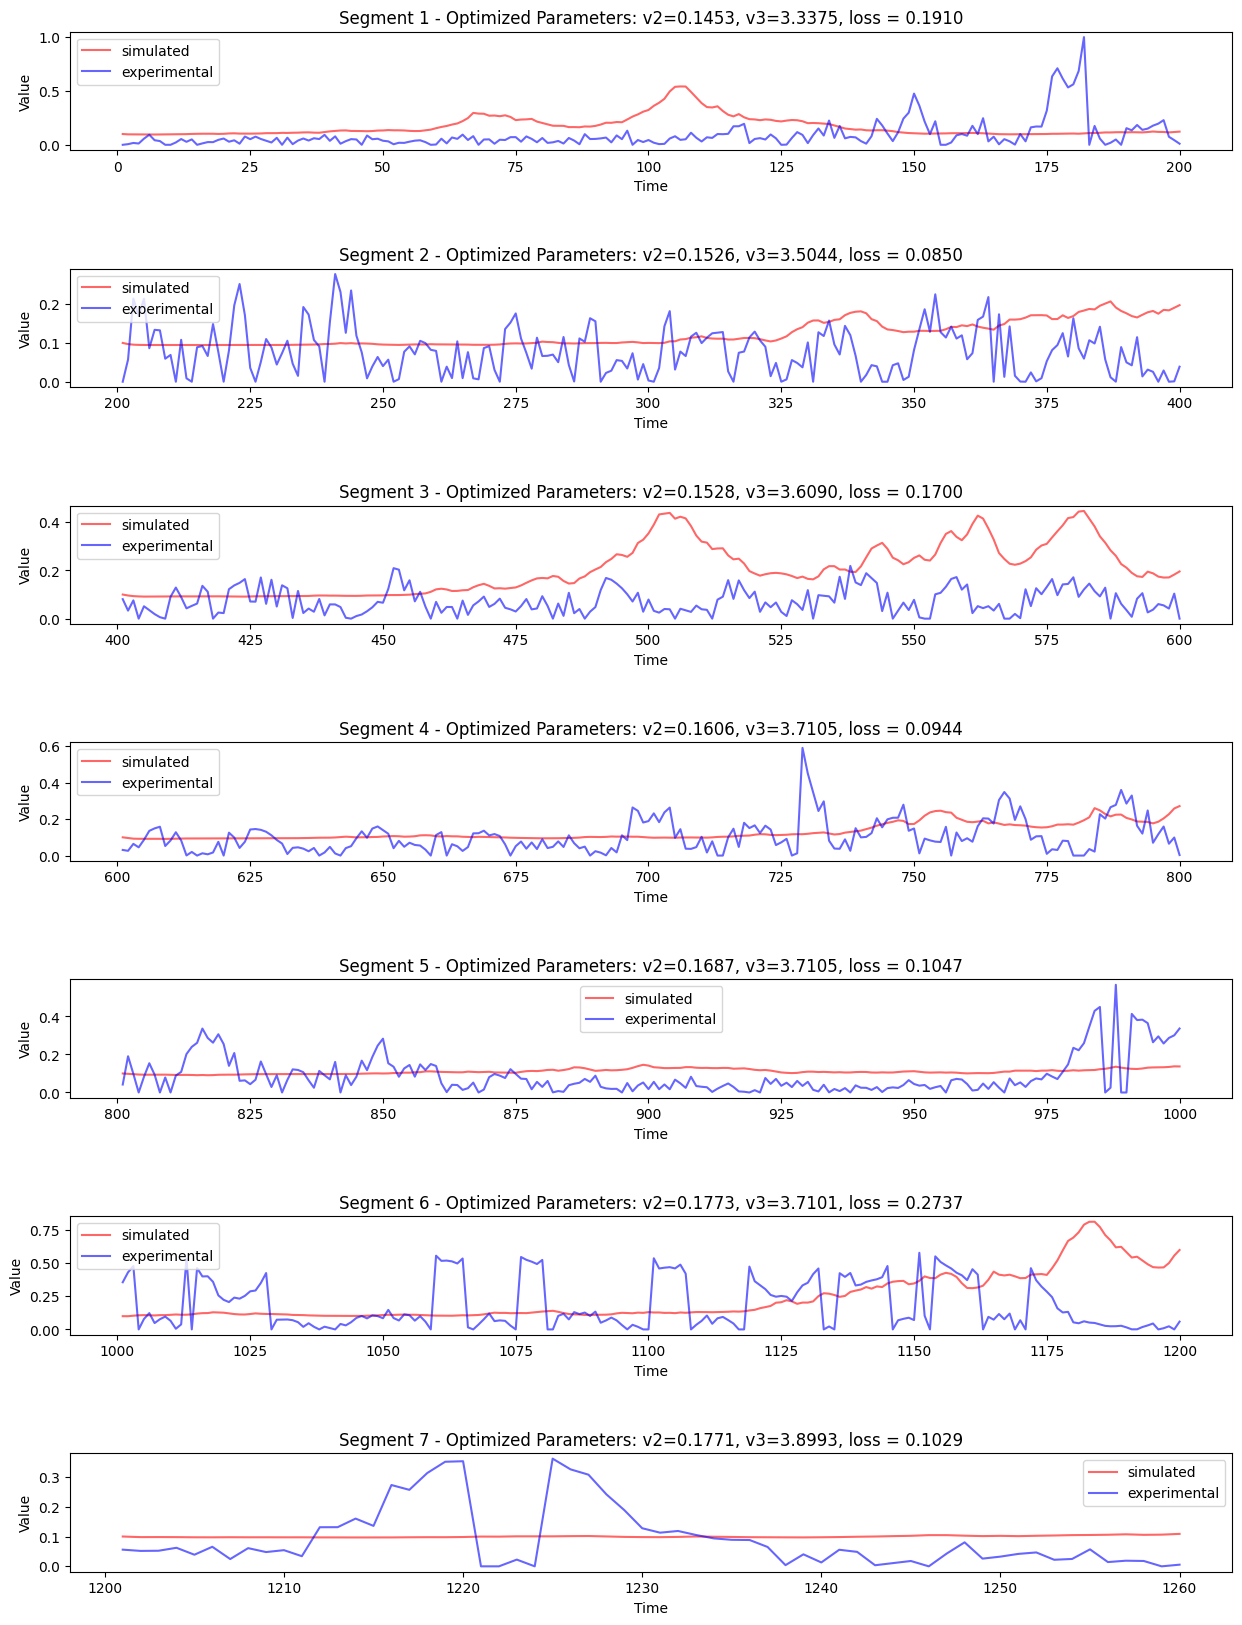

Best V2: 0.162044430362084
Best V3: 3.640190982921923


In [225]:
experimental_data = pd.read_csv('Hypoxia Data 2 (Group 1).xlsx - Sheet1.csv')
time = experimental_data.iloc[:, 0]
Ca = experimental_data.iloc[:, 1] # Assuming h is in the third column
params = {
        'IP3': 0.5,'v1': 6,'v2': 0.11,
        'v3': 0.9,'c0': 2,'c1': 0.185,
        'a2': 0.2,'d1': 0.13,'d2': 1.049,
        'd3': 0.9434,'d5': 0.08234,'k3': 0.1,
        'dt': 0.1, 'Nd': 2
    }
model = LiRinzel(params)
sim_data, objective_loss, v2_opt, v3_opt = model.fit(Ca, time, 'RMSE')
v2_best, v3_best = np.mean(v2_opt), np.mean(v3_opt)
print("Best V2:", v2_best)
print("Best V3:", v3_best)

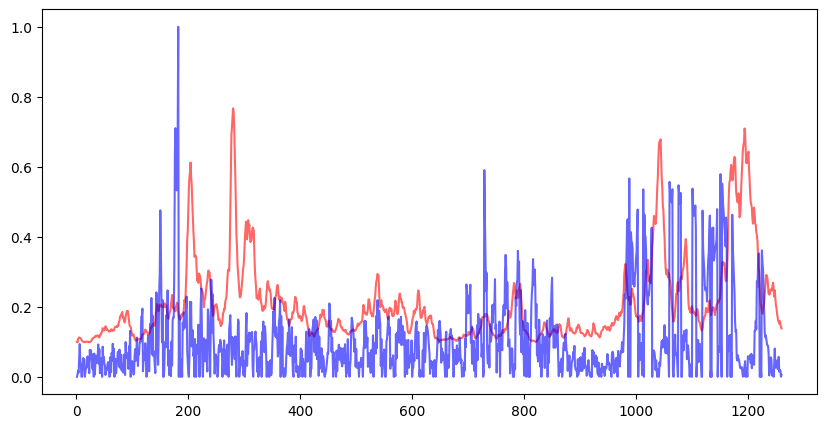

KLD:  -178.63484162999737
RMSE:  0.19367381730696295


In [226]:
fig1 = plt.figure(figsize=(10, 5))
plt.plot(time, sim_data, 'r-', alpha = 0.6)
plt.plot(experimental_data.iloc[:,0], experimental_data.iloc[:,1] , 'b-', alpha = 0.6)
plt.show()

kld = model.KLDivergence(Ca, sim_data)
rmse = model.RMSE(Ca, sim_data)
print('KLD: ', kld)
print('RMSE: ', rmse)

In [229]:
import numpy as np
import plotly.graph_objects as go
import seaborn as sns

# Assuming v2_opt, v3_opt, and objective_loss are your input arrays.
# You can use Seaborn's color palette for consistency
palette = sns.color_palette("viridis", as_cmap=True)

# Interpolation (if you want a smooth surface)
from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[min(v2_opt):max(v2_opt):200j, min(v3_opt):max(v3_opt):200j]
Z_interp = griddata((v2_opt, v3_opt), objective_loss, (grid_x, grid_y), method='cubic')

# Create an interactive 3D surface plot with Plotly
data = [
    go.Surface(z=Z_interp, x=grid_x, y=grid_y, colorscale='Viridis'),
    go.Scatter3d(
        x=[v2_opt[-1]],  # Optimized v2 value
        y=[v3_opt[-1]],  # Optimized v3 value
        z=[objective_loss[-1]],  # Objective loss at the optimized point
        mode='markers',  # Set marker style
        marker=dict(size=10, color='red')  # Customize marker size and color
    )
]

fig = go.Figure(data=data)

# Customize the plot
fig.update_layout(
    title="Interactive 3D Plot of Objective Loss",
    scene=dict(
        xaxis_title='v2_opt',
        yaxis_title='v3_opt',
        zaxis_title='Objective Loss'
    ),
    autosize=False,
    width=800,
    height=600
)

# Show the interactive plot
fig.show()

In [233]:
simulated_data = pd.DataFrame({'Time': time, 'Ca': sim_data})
simulated_data.to_csv('simulated_data.csv')